In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from node import Node
from graph import DiGraph
import numpy as np
import matplotlib.pyplot as plt
import pyaudio

In [3]:
from vco import VCO
from amplifier import Amplifier
from voltage import Voltage   
from mixer import Mixer
from rack import Rack
from adsr import ADSR
from lpfilter import Filter

In [32]:
rack = Rack()
fs = 48000 # Hz

# Voltage Controlled Oscillators
vco_frequency = Voltage(value = 110)
vco_0 = VCO(frequency = vco_frequency, fs = fs, shape = 'square')

## Envelope generators

env_trigger = Voltage(value = 0)

env_amp_a = Voltage(value = 5)
env_amp_d = Voltage(value = 50)
env_amp_s = Voltage(value = 0.9)
env_amp_r = Voltage(value = 50)

envelope_amplitude = ADSR(
    trigger = env_trigger,
    attack = env_amp_a, 
    delay = env_amp_d, 
    sustain = env_amp_s, 
    release = env_amp_r)

env_filter_a = Voltage(value = 5)
env_filter_d = Voltage(value = 50)
env_filter_s = Voltage(value = 0.1)
env_filter_r = Voltage(value = 50)

envelope_filter = ADSR(
    trigger = env_trigger,
    attack = env_filter_a, 
    delay = env_filter_d, 
    sustain = env_filter_s, 
    release = env_filter_r)

# Filter

filter_frequency = Voltage(value = 0.2)
filter_resonance = Voltage(value = 0.0)
filter_env_amount = Voltage(value = 0.8)

filter_offset = Voltage(value = 0.1)
filter_env_offset = Mixer(inputs = [filter_offset, envelope_filter])
filter_env_ampl = Amplifier(value = filter_env_offset, gain = filter_env_amount)

filter_0 = Filter(
    value = vco_0, 
    frequency = filter_env_ampl, 
    resonance = filter_resonance)

# Amplitude
output = Amplifier(value = filter_0, gain = envelope_amplitude)


modules = [vco_frequency, 
           vco_0,
           env_trigger, 
           env_amp_a, 
           env_amp_d, 
           env_amp_s, 
           env_amp_r, 
           envelope_amplitude, 
           env_filter_a, 
           env_filter_d, 
           env_filter_s, 
           env_filter_r, 
           envelope_filter, 
           filter_frequency,
           filter_resonance,
           filter_env_amount,
           filter_offset,
           filter_env_offset,
           filter_env_ampl,
           filter_0,
           output]

for module in modules:
    rack.add_object(module)

Voltage_0
VCO_0
Voltage_1
Voltage_2
Voltage_3
Voltage_4
Voltage_5
ADSR_0
Voltage_6
Voltage_7
Voltage_8
Voltage_9
ADSR_1
Voltage_13
Mixer_0
Voltage_12
Amplifier_0
Voltage_11
Filter_0
Amplifier_1


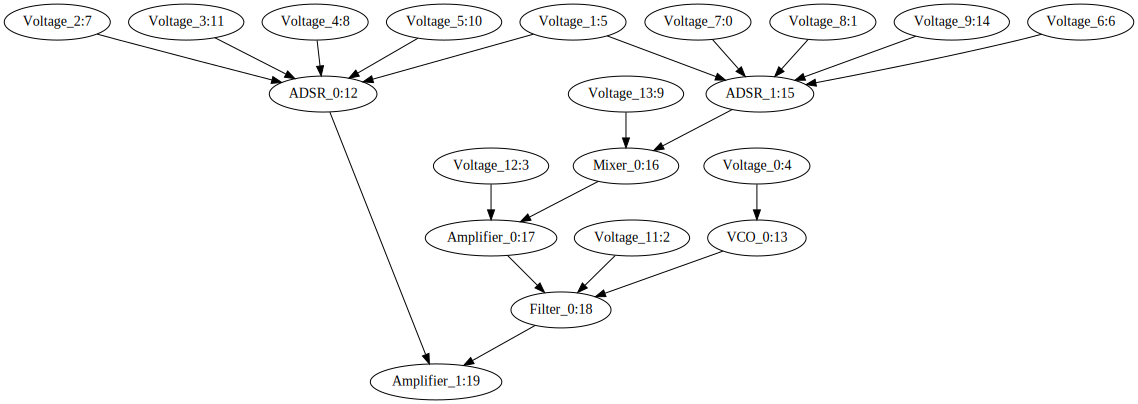

In [35]:
rack.plot()

In [36]:
p = pyaudio.PyAudio()
stream = p.open(format=p.get_format_from_width(2),
            channels=1,
            rate=fs,
            output=True)

buffer_size, n_buffers = 512, 512
history_buffer = np.zeros((n_buffers, buffer_size))
iteration = 0
for buffer_id in range(n_buffers):
    buffer_int = np.zeros(buffer_size, dtype=np.int16)
    buffer_float = np.zeros(buffer_size, dtype=np.float32)
    for sample_id in range(buffer_size):
        iteration = sample_id + buffer_id * buffer_size
        if iteration == 0:
            env_trigger.outputs[0] = 0
        if iteration == buffer_size * 128:
            env_trigger.outputs[0] = 1
        if iteration == buffer_size * 256:
            env_trigger.outputs[0] = 0
            
        rack.step()
        
        sample = output.outputs[0] * 0.5 # Volume
        sample *= 2**16/2 # Int range normalization
        buffer_int[sample_id] = sample
    history_buffer[buffer_id, :] = buffer_int
    stream.write(buffer_int.tobytes()) 
    
stream.close()

all right
Status.IDLE
1
0
going attack
all right
Status.IDLE
1
0
going attack
going delay
going delay
going sustain
going sustain
all right
Status.SUSTAIN
0
1
going release
all right
Status.SUSTAIN
0
1
going release
going idle
going idle


all right
Status.IDLE
1
0
going attack
all right
Status.IDLE
1
0
going attack
going delay
going delay
going sustain
going sustain
all right
Status.SUSTAIN
0
1
going release
all right
Status.SUSTAIN
0
1
going release
going idle
going idle


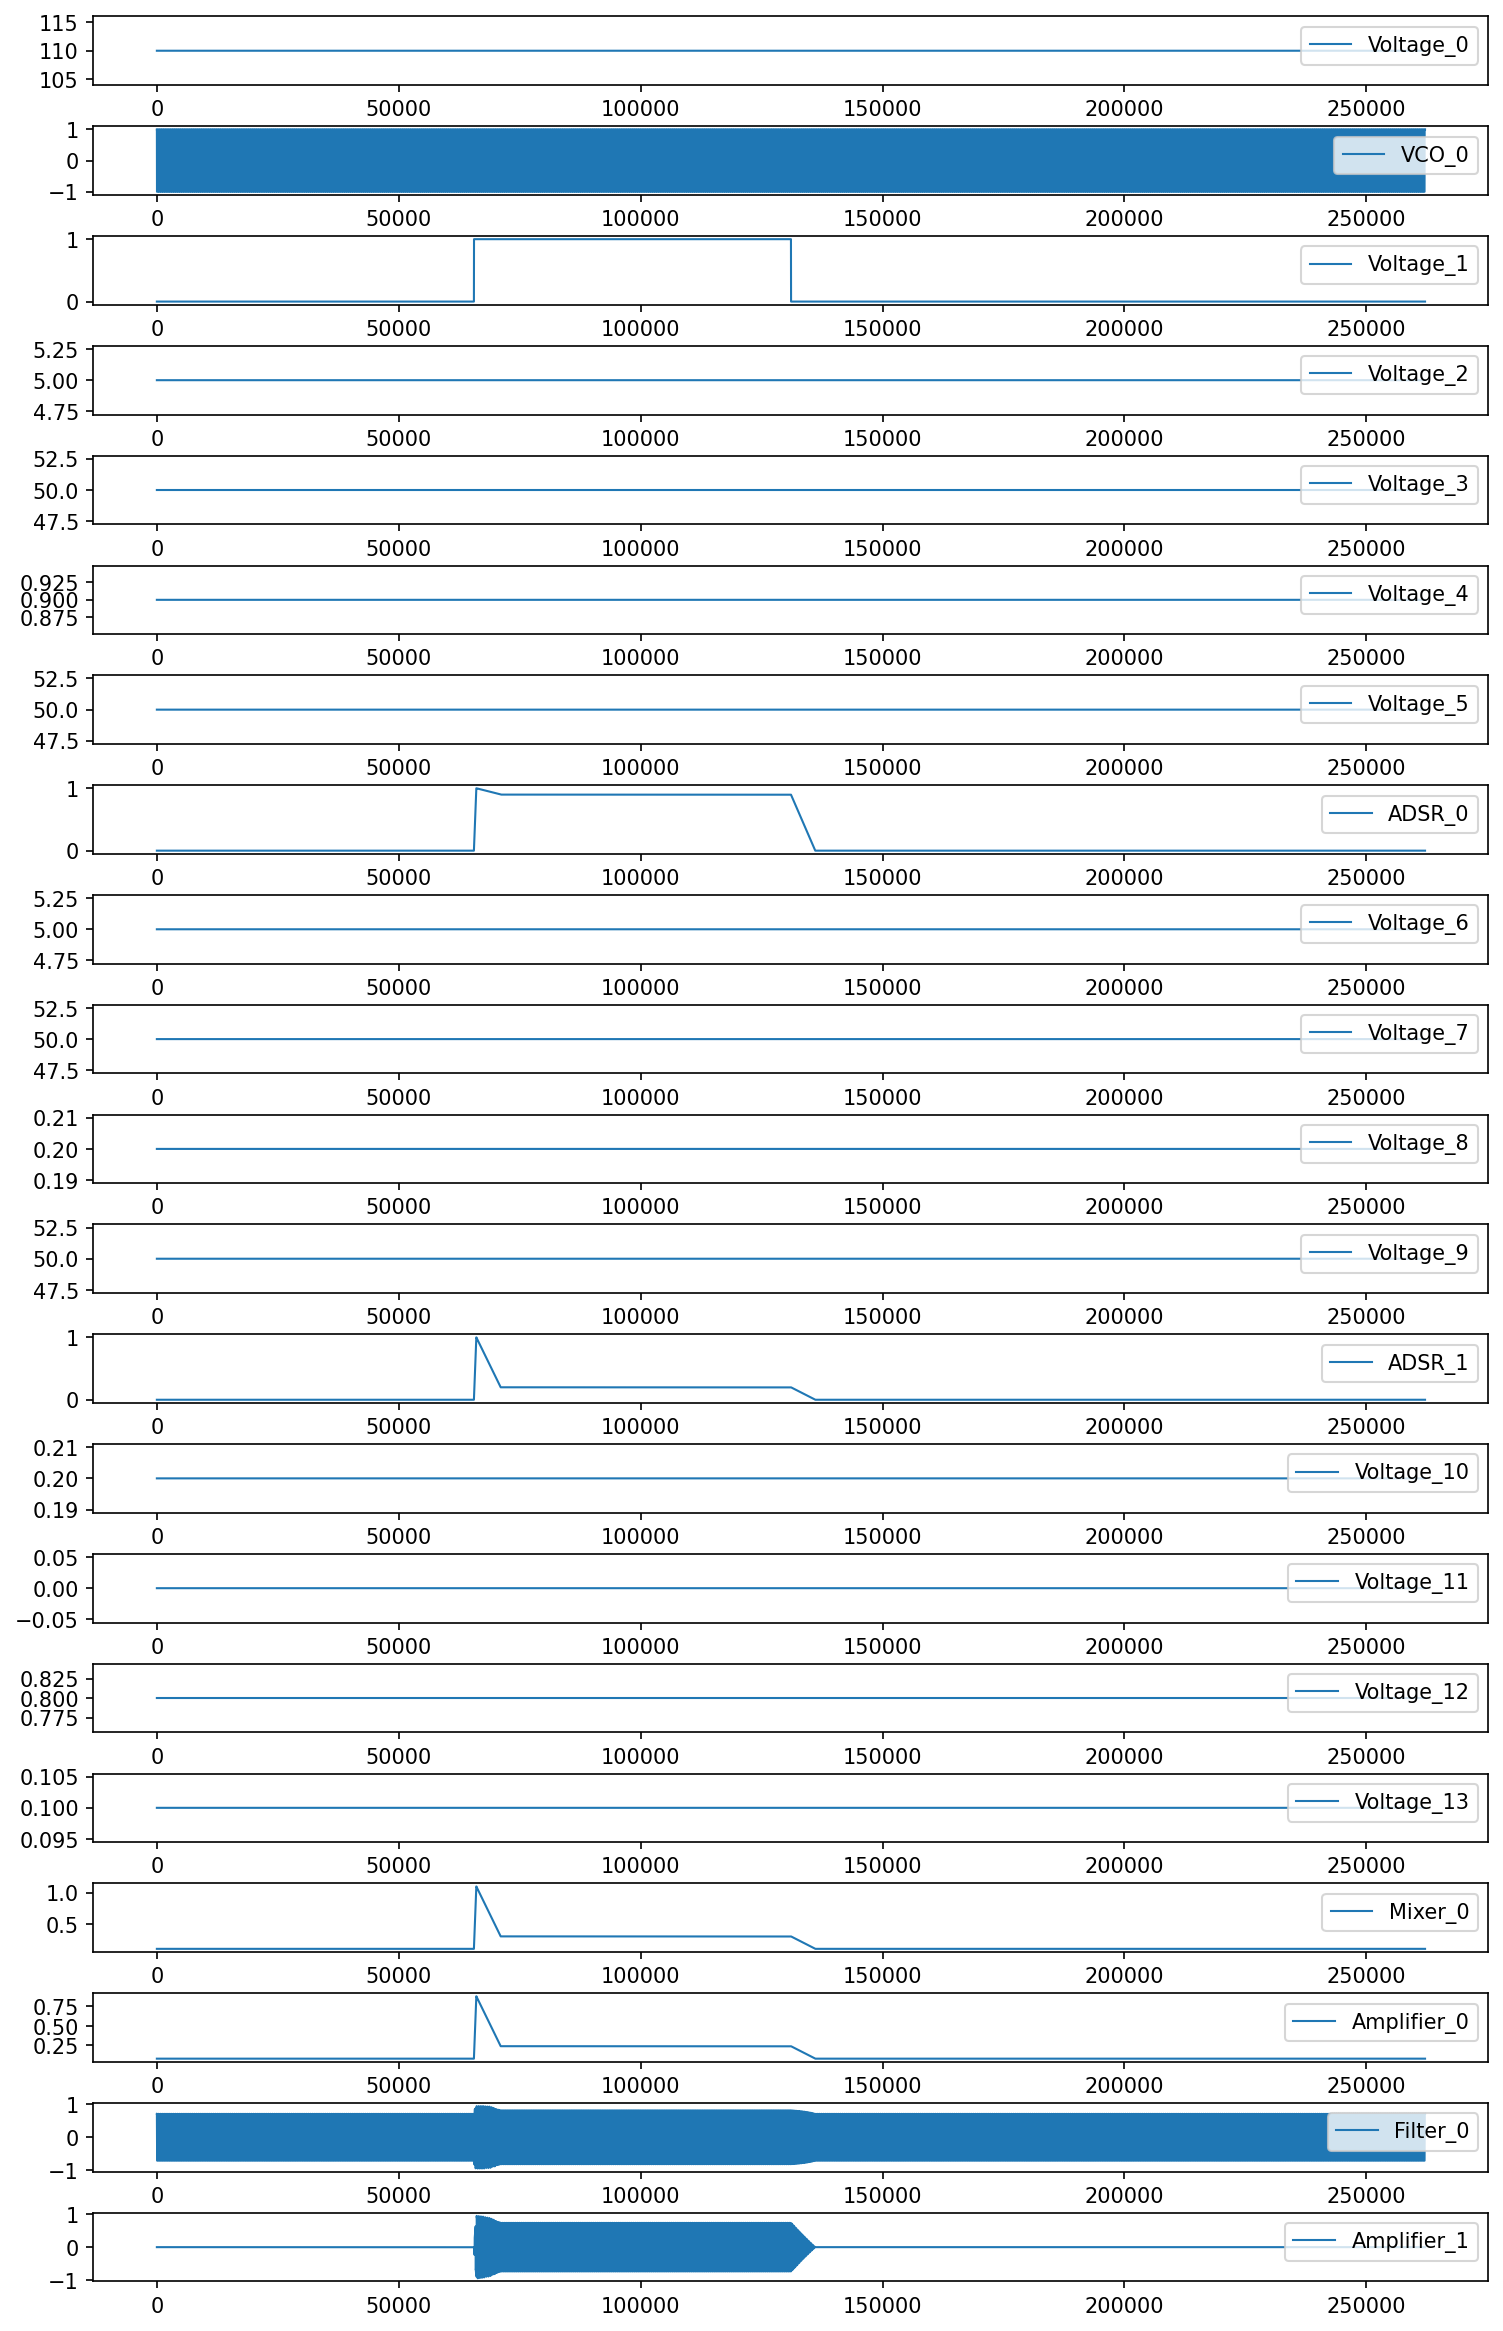

In [30]:
n_ite = buffer_size * n_buffers
probe = {k:np.zeros(n_ite) for k in rack.objects.keys()}

for iteration in range(n_ite):
    if iteration == 0:
        env_trigger.outputs[0] = 0
    if iteration == buffer_size * 128:
        env_trigger.outputs[0] = 1
    if iteration == buffer_size * 256:
        env_trigger.outputs[0] = 0
    rack.step()
    for object_name in rack.objects.keys():
        probe[object_name][iteration] = rack.objects[object_name].outputs[0]
        
plt.figure(figsize = (12, 20), dpi = 150)
for i, object_name in enumerate(rack.objects.keys()):
    plt.subplot(len(rack.objects.keys()), 1, i+1)
    plt.plot(probe[object_name], label = object_name, linewidth = 1)
    plt.legend(loc = 'upper right')
plt.subplots_adjust(hspace = 0.6)